In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Example

In [17]:
x = torch.arange(-3.0, 3.0, 0.01)
beta = 1000 # steepness
y = torch.sigmoid(beta * x)

With a high steepness, we basically get a step function. 

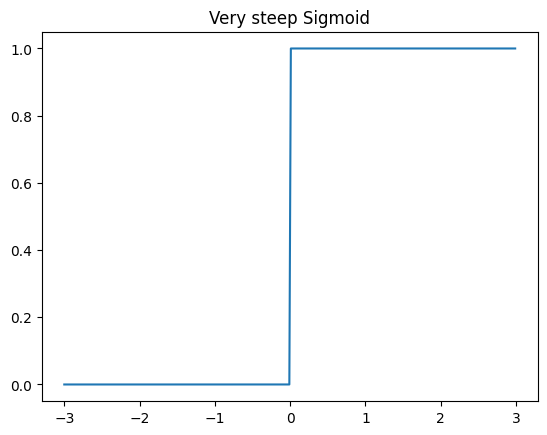

In [18]:
plt.plot(x, y)
plt.title('Very steep Sigmoid');

However, this is totally differentiable:

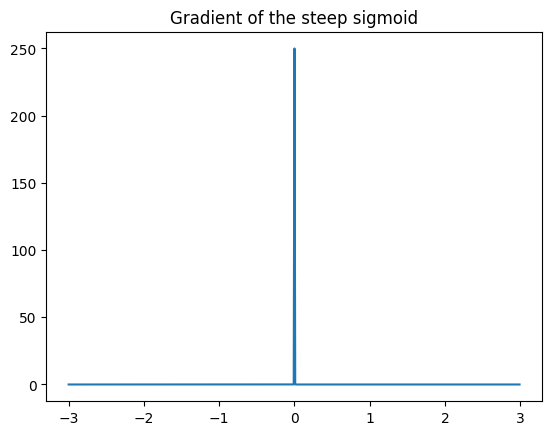

In [19]:
x = torch.arange(-3.0, 3.0, 0.01, requires_grad=True)
beta = 1000
y = torch.sigmoid(beta * x)

y.sum().backward() # the combining function is arbitrary here
plt.plot(x.detach(), x.grad.detach())
plt.title('Gradient of the steep sigmoid');

# Stochastic Neural Network

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

batch_size = 30

train_dataset = torchvision.datasets.MNIST('../../Neural-Networks/data', train = True, transform = transform)
test_dataset = torchvision.datasets.MNIST('../../Neural-Networks/data', train = False, transform = transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [10]:
f, l = next(iter(train_loader))

In [ ]:
class SigmoidApproximation(nn.Module):
    # implementation ripped from Florian's SimpleNN
    def __init__(self, beta = 100):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 10)        

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.relu()
        x = self.fc2(x)
        return x

model = SigmoidApproximation()

